In [27]:
# Numpy for working with Arrays
import numpy as np

# Pandas for working with data tables
import pandas as pd

# SciPy implements many different numerical algorithms
import scipy as sp
import scipy.stats as stats
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

# Module for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from cycler import cycler

# scikit learn packages
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


In [28]:
### load data from csv files
water_values = pd.read_csv('./data/train_set_values.csv')
water_labels = pd.read_csv('./data/train_set_labels.csv')

# list categorical features to be turned into dummy variables:
cat_features = ['id', 'region_code', 'district_code', 'basin', 'region', 'public_meeting', \
                'scheme_management', 'permit', 'extraction_type', 'extraction_type_class', \
                'management', 'water_quality', 'quantity', \
                'source', 'waterpoint_type', 'recorded_by', 'funder', 'installer', \
               'lga', 'ward', 'scheme_name', 'management_group', 'subvillage', 'wpt_name', \
               'payment_type', 'source_class', 'payment', 'extraction_type_group', 'quality_group', \
                'quantity_group', 'source_type', 'waterpoint_type_group']

# list numeric features
num_features = ['id', 'gps_height', 'longitude', 'latitude', 'amount_tsh', 'num_private', 'construction_year' \
                , 'population', 'date_recorded']

# make dataframe of just the categorical features, use id as index
water_cat = water_values.loc[:,cat_features].set_index('id')

# make dataframe of just numeric (basically, the rest of the columns), use id as index
water_num = water_values.loc[:,num_features].set_index('id')


# prepare test data for model prediction
test = pd.read_csv('./test_set_values.csv')

# make dataframe of just the categorical features, use id as index
test_cat = test.loc[:,cat_features].set_index('id')

# make dataframe of just numeric (basically, the rest of the columns), use id as index
test_num = test.loc[:,num_features].set_index('id')

In [29]:
# remove categorical values that occur fewer than threshold
threshold = 2 # Anything that occurs less than this will be removed.
for col in water_cat:
    vc = water_cat[col].value_counts()
    vals_to_remove = vc[vc < threshold].index.values
    water_cat.loc[water_cat[col].isin(vals_to_remove), col] = None

    
# impute 'missing' for categorical NaNs 
for dataset in [water_cat, test_cat]:
    for col in dataset:
        idx = dataset.loc[:,col][dataset[col].isnull() == True].index
        dataset.set_value(idx, col, 'missing')
        idx = dataset.loc[:,col][dataset[col] == 0].index
        dataset.set_value(idx, col, 'missing')


imp_water = pd.read_csv('water_num_imputed.csv')
imp_test = pd.read_csv('test_num_imputed.csv')

for col in water_num:
    if col in ['gps_height', 'longitude', 'latitude', 'construction_year']:
        water_num.loc[water_num[col] == 0, col] = imp_water[col]

for col in test_num:
    if col in ['gps_height', 'longitude', 'latitude', 'construction_year']:
        test_num.loc[test_num[col] == 0, col] = imp_test[col]
        
        

# convert status labels to numeric
water_labels['status_group'] = water_labels.status_group.factorize()[0]


# replace 0s with NaN in columns where 0 likely doesn't mean 'zero'
for dataset in [water_num, test_num]:
    for col in ['population', 'construction_year','num_private', 'longitude']:
        dataset[col].replace(0, np.nan, inplace = True)

# removed: , 'amount_tsh', 'gps_height'

# transform date to float
for dataset in [water_num, test_num]:
    dataset['date_recorded'] = pd.to_datetime(dataset['date_recorded'])
    dataset['month'] = dataset['date_recorded'].dt.month
    dataset['year'] = dataset['date_recorded'].dt.year
    dataset['date_recorded'] = (dataset['date_recorded'] - dataset['date_recorded'].min())  / np.timedelta64(1,'D')


# preprocessing steps

# encode labels to floats
le = preprocessing.LabelEncoder()

# labels to floats, row by row (le doesn't work across df's)
for col in water_cat:
    le.fit(water_cat[col].append(test_cat[col]))
    water_cat.loc[:,col] = le.transform(water_cat.loc[:,col])
    test_cat.loc[:,col] = le.transform(test_cat.loc[:,col])

# same for test:
#for col in test_cat:
#    encoded = le.transform(test_cat.loc[:,col])
#    test_cat.loc[:,col] = encoded

In [30]:
# preprocessing steps

# encode labels to floats
le = preprocessing.LabelEncoder()

# labels to floats, row by row (le doesn't work across entire df's)
for col in water_cat:
    le.fit(water_cat[col].append(test_cat[col]))
    water_cat.loc[:,col] = le.transform(water_cat.loc[:,col])
    test_cat.loc[:,col] = le.transform(test_cat.loc[:,col])

# same for test:
#for col in test_cat:
#    encoded = le.transform(test_cat.loc[:,col])
#    test_cat.loc[:,col] = encoded

In [31]:
# define one hot encoder (for dummy variables)
enc = preprocessing.OneHotEncoder(handle_unknown = 'ignore')

# make dummy variables
water_cat = enc.fit_transform(water_cat)

# fit test data to same dummies
test_cat = enc.transform(test_cat)

# impute data
imp = preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0, verbose=0, copy=True)
water_num = imp.fit_transform(water_num)

# transform test
test_num = imp.transform(test_num)


# standardize numeric variables
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
water_num = minmax_scale.fit_transform(water_num)

# transform test
test_num = minmax_scale.transform(test_num)


print 'water_cat shape: %s' % (str(water_cat.shape))
print 'test_cat shape: %s' % (str(test_cat.shape))
print 'water_num shape: %s' % (str(water_num.shape))
print 'test_num shape: %s' % (str(test_num.shape))



water_cat shape: (59400, 20702)
test_cat shape: (14850, 20702)
water_num shape: (59400L, 10L)
test_num shape: (14850L, 10L)


In [32]:
# set to float32 (from float64) to conserve memory

water_cat = sp.sparse.csr_matrix(water_cat, dtype = 'float32')
test_cat = sp.sparse.csr_matrix(test_cat, dtype = 'float32')
water_num = sp.sparse.csr_matrix(water_num, dtype = 'float32')
test_num = sp.sparse.csr_matrix(test_num, dtype = 'float32')


### prepare variables for model fitting

# convert to sparse matrix
water_num = csr_matrix(water_num)

# concatenate 
X = hstack([water_num, water_cat])
Xtest = hstack([test_num, test_cat]) # capital Xtest = real test set for submission

# flatten label column into a 1-D array called y
y = np.ravel(water_labels['status_group'])

# split into training/test sets for crossval
xtrain, xtest, ytrain, ytest = \
cross_validation.train_test_split(X, y, test_size=0.2, random_state=12345)

### create DF to hold predictions for training ensemble
ens_df = pd.DataFrame()

### create DF to hold predictions for final test submission
pred_df = pd.DataFrame()

### prepare for ROC curves
# binarize labels
y_test = label_binarize(ytest, classes = [0,1,2])


In [8]:
#proba_df = pd.DataFrame()

In [9]:
##### Model building #####

In [33]:
### Logistic Regression Classifier
# instantiate a logistic regression model, and fit with train
clf_lr = LogisticRegression(penalty = 'l1', C = 1)
clf_lr = clf_lr.fit(xtrain, ytrain)
print 'Logistic Regression test score: %f' % (clf_lr.score(xtest,ytest))

# run prediction on test
yhat_log_test = clf_lr.predict(xtest)

# run probability prediction to df (for ROC)
yhat_lr_proba_test = clf_lr.predict_proba(xtest)

# add prediction to ensemble df
ens_df['lr'] = yhat_log_test

#0.787710

Logistic Regression test score: 0.788047


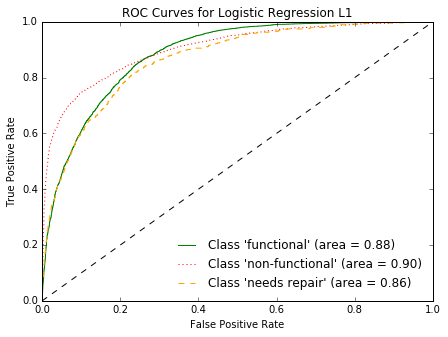

In [34]:
### ROC curve
# get number of classes
n_classes = yhat_lr_proba_test[1]
classes = ['functional', 'non-functional', 'needs repair']

# create dicts to hold false positives, true positives, areas under curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate curves
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], yhat_lr_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))

# set colors
plt.rc('axes', prop_cycle=(cycler('color', ['g', 'r', 'orange']) +
                           cycler('linestyle', ['-', ':', '--'])))

# build plot lines for each class
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='Class \'{0}\' (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--') # dotted diagonal line
plt.xlim([0.0, 1.0]) # axis limits
plt.ylim([0.0, 1.0]) # axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression L1')
plt.legend(loc="lower right", frameon=False)
plt.savefig('ROC_lr.pdf',bbox_inches='tight')

In [35]:
### Random Forest Classifier
# instantiate a ### Random Forest Classifiern model, and fit with train
clf_rf = RandomForestClassifier(n_estimators=100)

# fit model on training
clf_rf.fit(xtrain, ytrain)

print 'Random Forest test score: %f' % (clf_rf.score(xtest, ytest))

# run prediction on test
yhat_rf_test = clf_rf.predict(xtest)

# run probability prediction to df (for ROC)
yhat_rf_proba_test = clf_rf.predict_proba(xtest)

# add prediction to ensemble df
ens_df['rf'] = yhat_rf_test


Random Forest test score: 0.808670


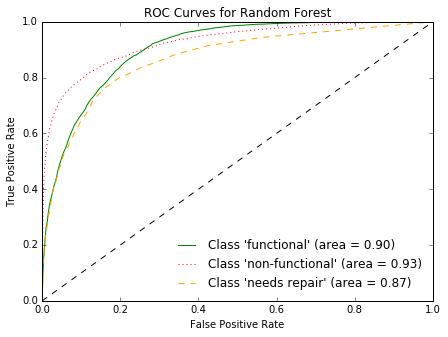

In [36]:
### ROC curve
# get number of classes
n_classes = yhat_rf_proba_test[1]
classes = ['functional', 'non-functional', 'needs repair']

# create dicts to hold false positives, true positives, areas under curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate curves
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], yhat_rf_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))

# set colors
plt.rc('axes', prop_cycle=(cycler('color', ['g', 'r', 'orange']) +
                           cycler('linestyle', ['-', ':', '--'])))

# build plot lines for each class
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='Class \'{0}\' (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--') # dotted diagonal line
plt.xlim([0.0, 1.0]) # axis limits
plt.ylim([0.0, 1.0]) # axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest')
plt.legend(loc="lower right", frameon=False)
plt.savefig('ROC_rf.pdf',bbox_inches='tight')

In [37]:
### Decision Tree Classifier
# define  classifier
clf_dt = DecisionTreeClassifier(max_features = None, criterion = 'gini', min_samples_leaf = 1, max_leaf_nodes = 1000)
# fit model on training
clf_dt.fit(xtrain, ytrain)

# check accuracy on test set
print 'Decision Tree test score: %f' % (clf_dt.score(xtest, ytest))

# run prediction on train
yhat_dt_test = clf_dt.predict(xtest)

# run probability prediction to df (for ROC)
yhat_dt_proba_test = clf_dt.predict_proba(xtest)

# add prediction to ensemble df
ens_df['dt'] = yhat_dt_test

#Decision Tree test score: 0.789226

Decision Tree test score: 0.786785


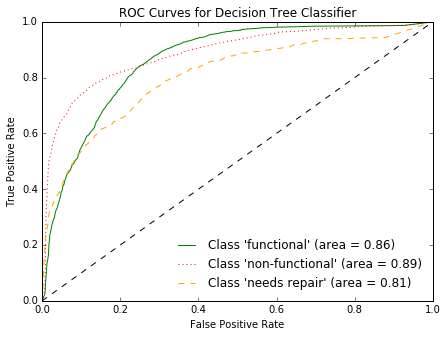

In [38]:
### ROC curve
# get number of classes
n_classes = yhat_dt_proba_test[1]
classes = ['functional', 'non-functional', 'needs repair']

# create dicts to hold false positives, true positives, areas under curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate curves
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], yhat_dt_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))

# set colors
plt.rc('axes', prop_cycle=(cycler('color', ['g', 'r', 'orange']) +
                           cycler('linestyle', ['-', ':', '--'])))

# build plot lines for each class
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='Class \'{0}\' (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--') # dotted diagonal line
plt.xlim([0.0, 1.0]) # axis limits
plt.ylim([0.0, 1.0]) # axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree Classifier')
plt.legend(loc="lower right", frameon=False)

plt.savefig('ROC_dt.pdf',bbox_inches='tight')

In [25]:
# check correlation of ensemble inputs
ens_df.apply(lambda s: ens_df.corrwith(s))

,lr,rf,dt
lr,1.000000,0.689163,0.674919
rf,0.689163,1.000000,0.680131
dt,0.674919,0.680131,1.000000


In [16]:
### Adaboost ensemble classifier

# convert dataframe to array
ens_array = ens_df.as_matrix()

# split ens_array into training/test sets for ada crossval
x_ens_train, x_ens_test, y_ens_train, y_ens_test = \
cross_validation.train_test_split(ens_array, ytest, test_size=0.2, random_state=12345)

# define model

ada = AdaBoostClassifier(DecisionTreeClassifier(max_features = None, criterion = 'gini'))

# fit adaboost
ada.fit(x_ens_train, y_ens_train)

scores = cross_validation.cross_val_score(ada,
        x_ens_test, y_ens_test)

# run probability prediction to df (for ROC)
yhat_ada_proba_test = ada.predict_proba(x_ens_test)

# here's what we do: train LR, RF, DT on train. predict on test set. train adaboost on test predictions. then train LR, RF, DT on full. 
# predict on TEST w/ all 3. predict adaboost on TEST

scores

array([ 0.79722922,  0.77749684,  0.81795196])

In [18]:
scores.mean()
### where we've left it: 4 classifiers trained, ada ensemb = 80.2. Worth doing full dataset train below?

0.79755933937739965

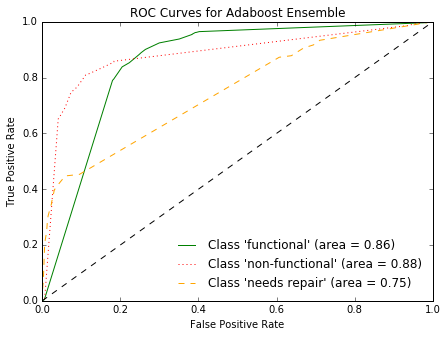

In [17]:
### ROC curve -- ensemble
# get number of classes

# re-binarize label for ensemble
y_test = label_binarize(y_ens_test, classes = [0,1,2])

n_classes = yhat_ada_proba_test[1]
classes = ['functional', 'non-functional', 'needs repair']

# create dicts to hold false positives, true positives, areas under curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate curves
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], yhat_ada_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))

# set colors
plt.rc('axes', prop_cycle=(cycler('color', ['g', 'r', 'orange']) +
                           cycler('linestyle', ['-', ':', '--'])))

# build plot lines for each class
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='Class \'{0}\' (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--') # dotted diagonal line
plt.xlim([0.0, 1.0]) # axis limits
plt.ylim([0.0, 1.0]) # axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Adaboost Ensemble')
plt.legend(loc="lower right", frameon=False)

plt.savefig('ROC_ada.png',bbox_inches='tight')

In [19]:
# train LR model on full dataset
clf_lr = clf_lr.fit(X, y)

# run prediction on FINAL TEST data
yhat_log_pred = clf_lr.predict(Xtest)

# add prediction to ensemble df
pred_df['lr'] = yhat_log_pred

# fit RF model on full dataset
clf_rf.fit(X, y)

# run prediction on FINAL TEST data
yhat_rf_pred = clf_rf.predict(Xtest)

# add prediction to ensemble df
pred_df['rf'] = yhat_rf_pred

# fit DT model on full dataset
clf_dt.fit(X, y)

# run prediction on FINAL TEST data
yhat_dt_pred = clf_dt.predict(Xtest)

# add prediction to ensemble df
pred_df['dt'] = yhat_dt_pred

In [20]:
# convert dataframe to array
pred_array = pred_df.as_matrix()

### Adaboost Ensemble: FINAL predictions

# fit adaboost on full training set (earlier was only on training split of test set)
ada.fit(ens_array, ytest)

predictions = ada.predict(pred_array)

In [24]:
# create submission

test['status_group'] = predictions

map_dict = {0: 'functional', 1: 'non functional', 2: 'functional needs repair'}
test['status_group'] = test['status_group'].map(map_dict)
test_submit = test[['id', 'status_group']]
test_submit.to_csv('submit_lr_fr_dt__ada_20160528b_impute_cleanencode_thresh2.csv', index = False)

In [ ]:
#### code pieces that were used along the way, but not a part of ensemble prediction

In [18]:
### K-Nearest Neighbors Classifier

# define  classifier
clf_kn = KNeighborsClassifier(n_neighbors=5)
# fit model on training
clf_kn.fit(xtrain, ytrain)

# check accuracy on test set
print 'KNN test score: %f' % (clf_kn.score(xtest, ytest))

# run prediction on train
yhat_kn_test = clf_kn.predict(xtest)

# add prediction to ensemble df
ens_df['kn'] = yhat_kn_test

KNN test score: 0.780976


In [ ]:
### Logistic Regression Classifier - l2
# instantiate a logistic regression model, and fit with train
clf_lr2 = LogisticRegression(penalty = 'l2', C = .3)
clf_lr2 = clf_lr2.fit(xtrain, ytrain)
print 'Logistic Regression l2 test score: %f' % (clf_lr2.score(xtest,ytest))

# run prediction on test
yhat_log2_test = clf_lr2.predict(xtest)

# add prediction to ensemble df
ens_df['lr2'] = yhat_log2_test

In [8]:
### Adaboost classifier

# define  classifier
clf_ada = AdaBoostClassifier(RandomForestClassifier(n_estimators=50))
# fit model on training
clf_ada.fit(xtrain, ytrain)
# check accuracy on test set
print 'Adaboost test score: %f' % (clf_ada.score(xtest, ytest))

# run prediction on train
yhat_ada_test = clf_ada.predict(xtest)

# add prediction to ensemble df
ens_df['ada'] = yhat_ada_test

### In the AM, check this score!!! ##### was .810943

Adaboost test score: 0.807155


In [7]:
### Naive Bayes

# define  classifier
clf_nb = MultinomialNB(alpha = 3, fit_prior = True)
# fit model on training
clf_nb.fit(xtrain, ytrain)
# check accuracy on test set
print 'Naive Bayes test score: %f' % (clf_nb.score(xtest, ytest))

# run prediction on train
yhat_nb_test = clf_nb.predict(xtest)

# add prediction to ensemble df
ens_df['nb'] = yhat_nb_test

Naive Bayes test score: 0.720370


In [ ]:
### Grid Search to optimize parameters for KNN Classifier
# prepare a range of values to test
X_dense = X.toarray()
n_neighbors = [4,5,6]    
weights = ['uniform', 'distance']
p  = [1,2]

# create and fit a ridge regression model, testing each alpha
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=[dict(n_neighbors=n_neighbors), dict(weights = weights),\
                                                 dict(p = p)])
grid.fit(X_dense, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)
print(grid.best_estimator_.weights)
print(grid.best_estimator_.p)


In [6]:
'''### Grid Search to optimize parameters for LogReg
# prepare a range of alpha values to test
C = np.array([1, .9, .8, .7, .5, .3, .1])
penalty = ['l1', 'l2']
# create and fit a ridge regression model, testing each alpha
model = LogisticRegression()
grid = GridSearchCV(estimator=model, param_grid=[dict(C=C), dict(penalty = penalty)])
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.penalty)

### best score: 0.788787878788
### best C: 1
### best penalty: l1

'''

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': array([ 1. ,  0.9,  0.8,  0.7,  0.5,  0.3,  0.1])}, {'penalty': ['l1', 'l2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)
0.788888888889
0.7
l2


In [ ]:
'''
### Grid Search to optimize parameters for RandForest
# prepare a range of alpha values to test
n_estimators = np.array([100, 200, 300])
criterion = ['gini']                         

# create and fit a ridge regression model, testing each alpha
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=[dict(n_estimators=n_estimators), dict(criterion = criterion)])
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.n_estimators)
print(grid.best_estimator_.criterion)

### best score: 0.800505050505
### best n_estimators: 300
### best criterion: gini
'''

In [8]:
'''
### Grid Search to optimize parameters for Decision Tree Classifier
# prepare a range of values to test
criterion = ['gini', 'entropy']    
max_features = ['sqrt', 'log2', None]
max_depth  = [2,3,4,None]
min_samples_leaf = np.array([1,3,5])
max_leaf_nodes = [None, 1000, 100]

# create and fit a ridge regression model, testing each alpha
model = DecisionTreeClassifier()
grid = GridSearchCV(estimator=model, param_grid=[dict(criterion=criterion), dict(max_features = max_features),\
                                                 dict(min_samples_leaf = min_samples_leaf), \
                                                 dict(max_leaf_nodes = max_leaf_nodes)])
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.max_features)
print(grid.best_estimator_.criterion)
print(grid.best_estimator_.min_samples_leaf)
print(grid.best_estimator_.max_leaf_nodes)
print(grid.best_estimator_.max_depth)


### best score: 0.780622895623
### best max_features: None
### best criterion: gini
### best min_samples_leaf: 1
### best max_leaf_nodes: 1000
### best max_depth: None
'''

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'criterion': ['gini', 'entropy']}, {'max_features': ['sqrt', 'log2', None]}, {'min_samples_leaf': array([1, 3, 5])}, {'max_leaf_nodes': [None, 1000, 100]}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)
0.780454545455
None
gini
1
1000
None


In [ ]:
'''### Grid Search to optimize parameters for Ensemble AdaBoost Classifier
# prepare a range of values to test
base_estimator = [DecisionTreeClassifier(max_features = None, criterion = 'gini', min_samples_leaf = 1, max_leaf_nodes = 1000),\
                  RandomForestClassifier(n_estimators = 100)]    
n_estimators = [25,50,100]
learning_rate   = [.75, 1, 1.25]


# create and fit a ridge regression model, testing each alpha
model = DecisionTreeClassifier()
grid = GridSearchCV(estimator=model, param_grid=[dict(base_estimator=base_estimator), dict(n_estimators = n_estimators),\
                                                 dict(learning_rate = learning_rate), \
                                                 dict(max_leaf_nodes = max_leaf_nodes)])
grid.fit(X_ens, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.base_estimator)
print(grid.best_estimator_.n_estimators)
print(grid.best_estimator_.learning_rate)
'''

In [ ]:
### Ensemble Voting Classifier
ens_vote = VotingClassifier([ ('rf', clf_rf), ('lr', clf_lr), ('kn', clf_kn)], voting='soft', weights=[1,1,1])
ens_vote.fit(xtrain, ytrain)


In [22]:
scores = cross_validation.cross_val_score(ens_vote,
        x_ens_test, y_ens_test)
print scores
print scores.mean()

[ 0.80201765  0.8030303   0.77623262]
0.793760191483


In [19]:
### Log Regression ensemble classifier

ens_lr = LogisticRegression(penalty = 'l2', C = 1)
ens_lr.fit(x_ens_train, y_ens_train)

scores = cross_validation.cross_val_score(ens_lr,
        x_ens_test, y_ens_test)

In [76]:
### Ensemble Voting Classifier: FINAL predictions
ens_vote = VotingClassifier([ ('rf', clf_rf), ('lr2', clf_lr2), ('ada', clf_ada), ('nb', clf_nb),('kn', clf_kn), ('lr', clf_lr), \
                             ('dt', clf_dt)], voting='soft', weights=[4,2,1,1,2,2,2])
ens_vote.fit(X, y)
predictions_vote = ens_vote.predict(Xtest)


In [69]:
# fit model on full dataset
clf_kn.fit(X, y)


# run prediction on FINAL TEST data
yhat_kn_pred = clf_kn.predict(Xtest)

# add prediction to ensemble df
pred_df['kn'] = yhat_kn_pred

In [70]:
# fit model on full dataset
clf_lr2.fit(X, y)


# run prediction on FINAL TEST data
yhat_lr2_pred = clf_lr2.predict(Xtest)

# add prediction to ensemble df
pred_df['lr2'] = yhat_lr2_pred

In [71]:
# fit model on full dataset
clf_nb.fit(X, y)


# run prediction on FINAL TEST data
yhat_nb_pred = clf_nb.predict(Xtest)

# add prediction to ensemble df
pred_df['nb'] = yhat_nb_pred

In [72]:
# fit model on full dataset
clf_ada.fit(X, y)


# run prediction on FINAL TEST data
yhat_ada_pred = clf_ada.predict(Xtest)

# add prediction to ensemble df
pred_df['ada'] = yhat_ada_pred

In [34]:
# run prediction on full training set X
yhat_train = clf_rf.predict(xtest)
#yhat_test = clf_rf.predict(Xtest)

# add prediction to ensemble df
ens_df['rf'] = yhat_train
#pred_df['rf'] = yhat_test
#TEST_df['rf'] = yhat_test

In [ ]:
'''
### Grid Search to optimize parameters for AdaBoost Classifier
# prepare a range of values to test
base_estimator = [DecisionTreeClassifier(max_features = None, criterion = 'gini', min_samples_leaf = 1, max_leaf_nodes = 1000)]    
n_estimators = [25,50,100]
learning_rate   = [.75, 1, 1.25]


# create and fit a ridge regression model, testing each alpha
model = AdaBoostClassifier()
grid = GridSearchCV(estimator=model, param_grid=[dict(base_estimator=base_estimator), dict(n_estimators = n_estimators),\
                                                 dict(learning_rate = learning_rate)])
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.n_estimators)
print(grid.best_estimator_.learning_rate)
'''


In [ ]:
'''
### Grid Search to optimize parameters for Support Vector Classification
# prepare a range of alpha values to test
C = np.array([1, .75, .5, .25, .1])
kernel  = ['rbf', 'linear', 'poly']
# create and fit a ridge regression model, testing each alpha
model = svm.SVC()
grid = GridSearchCV(estimator=model, param_grid=[dict(C=C), dict(kernel = kernel)])
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.kernel)

# best score = 0.77164983165
# best C = 1.0
# best kernel = linear
'''

In [7]:
### support vector machine
clf_svm = svm.SVC(C=1.0, kernel = 'linear')
clf_svm.fit(xtrain, ytrain)

# test accuracy on test
clf_svm.score(xtest, ytest)

0.78518518518518521

In [ ]:
# run prediction on full training set X
yhat_train = clf_svm.predict(X)
yhat_test = clf_svm.predict(Xtest)

# add prediction to ensemble df
ens_df['svm'] = yhat_train
pred_df['svm'] = yhat_test

In [ ]:
'''### Grid Search to optimize parameters for Naive Bayes
# prepare a range of alpha values to test
alpha = np.array([1, 3, 5, 10])
fit_prior   = [True, False]
# create and fit a ridge regression model, testing each alpha
model = MultinomialNB()
grid = GridSearchCV(estimator=model, param_grid=[dict(alpha = alpha), dict(fit_prior = fit_prior)])
grid.fit(water_cat, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.C)
print(grid.best_estimator_.penalty)

# best score = 0.719023569024
# best alpha = 3
# best fit_prior = True
'''

In [ ]:
# run prediction on full training set X
yhat_train = clf_nb.predict(water_cat)
yhat_test = clf_nb.predict(test_cat)

# add prediction to ensemble df
ens_df['nb'] = yhat_train
pred_df['nb'] = yhat_test

In [ ]:
# save ensemble vectors to file
ens_df.to_csv('ens_df.csv', index = False)
pred_df.to_csv('pred_df.csv', index = False)

In [ ]:
# Voting
VotingClassifier(estimators=[('lr', model_l1), ('rf', clf_rf), ('dt', clf_dt)], voting='hard')
VotingClassifier.fit(X,y)
VotingClassifier.predict(X)

In [ ]:
## ensemble adaboost
ada_ens = AdaBoostClassifier()

# fit adaboost
ada_ens.fit(xtrain_ens, ytrain)

# test accuracy on test
ada_ens.score(xtest_ens, ytest)


In [ ]:
### Ensemble log reg classifier
model_l2_ens = LogisticRegression(penalty = 'l1')
model_l2_ens = model_l2_ens.fit(xtrain_ens, ytrain)

# check the accuracy on the test set
model_l2_ens.score(xtest_ens, ytest)

In [ ]:
##### random code chunks below this line #####

In [ ]:
###############################################

In [ ]:
# received error that test dataset does not have as many columns as training (3dummy columns missing)
# this is to find out which ones
mask = np.in1d(X.columns, Xtest.columns)
print np.where(~mask)[0]

